In [2]:
import pandas as pd
import smile_extract
import src
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from src.crystal_models import SoftnormScaler

In [4]:
state_mapper = {
    'Hold Center (CST Cue)': 'Hold Center (Task Cue)',
    'Hold Center (RTT Cue)': 'Hold Center (Task Cue)',
}
tf = (
    pd.read_pickle('../results/trialframe/Dwight/2025-01-07/Dwight_2025-01-07_tf.pkl')
    .set_index(['block','task','result','state'],append=True)
    .loc[:,['hand position','motor cortex']]
    .pipe(src.munge.multivalue_xs,keys=['CST','RTT'],level='task')
    .xs(level='result',key='success')
    .rename(index=state_mapper,level='state')
)
tf

channel                                                                                   hand position  \
signal                                                                                                x   
trial_id time                   block                                task state                           
153      0 days 00:00:00        reward-type-medium-large-cst-rtt-dco CST  Reach to Center    122.566097   
         0 days 00:00:00.010000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center    122.554410   
         0 days 00:00:00.020000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center    122.555826   
         0 days 00:00:00.030000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center    122.561832   
         0 days 00:00:00.040000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center    122.560529   
...                                                                                                 ...   
151      0 days 00:00:03.040000 reward-type-medium-cst-rtt-dco       RTT  Success            174.859929   
         0 days 00:00:03.050000 reward-type-medium-cst-rtt-dco       RTT  Success            175.465318   
         0 days 00:00:03.060000 reward-type-medium-cst-rtt-dco       RTT  Success            175.970646   
         0 days 00:00:03.070000 reward-type-medium-cst-rtt-dco       RTT  Success            176.348664   
         0 days 00:00:03.080000 reward-type-medium-cst-rtt-dco       RTT  Success            176.616054   

channel                                                                                                \
signal                                                                                              y   
trial_id time                   block                                task state                         
153      0 days 00:00:00        reward-type-medium-large-cst-rtt-dco CST  Reach to Center  831.244227   
         0 days 00:00:00.010000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center  831.228788   
         0 days 00:00:00.020000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center  831.221718   
         0 days 00:00:00.030000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center  831.242384   
         0 days 00:00:00.040000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center  831.237312   
...                                                                                               ...   
151      0 days 00:00:03.040000 reward-type-medium-cst-rtt-dco       RTT  Success          902.625669   
         0 days 00:00:03.050000 reward-type-medium-cst-rtt-dco       RTT  Success          902.809201   
         0 days 00:00:03.060000 reward-type-medium-cst-rtt-dco       RTT  Success          902.931558   
         0 days 00:00:03.070000 reward-type-medium-cst-rtt-dco       RTT  Success          902.991158   
         0 days 00:00:03.080000 reward-type-medium-cst-rtt-dco       RTT  Success          903.072071   

channel                                                                                               \
signal                                                                                             z   
trial_id time                   block                                task state                        
153      0 days 00:00:00        reward-type-medium-large-cst-rtt-dco CST  Reach to Center   9.530940   
         0 days 00:00:00.010000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center   9.532851   
         0 days 00:00:00.020000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center   9.530035   
         0 days 00:00:00.030000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center   9.524659   
         0 days 00:00:00.040000 reward-type-medium-large-cst-rtt-dco CST  Reach to Center   9.531127   
...                                                                                              ...   
151      0 days 00:00:03.040000 reward-type-medium-cst-rtt-dco       RTT  Success          13.

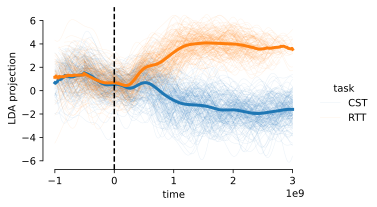

In [31]:
lda_pipe = Pipeline([
    # ('preprocess', SoftnormScaler()),
    # ('pca', PCA(n_components=15)),
    ('svd', TruncatedSVD(n_components=15)),
    ('lda', LinearDiscriminantAnalysis()),
])

data = (
    tf
    ['motor cortex']
    .groupby('trial_id',group_keys=False)
    .apply(src.time_slice.reindex_trial_from_event,event='Hold Center (Task Cue)')
    .groupby('trial_id')
    .transform(smile_extract.smooth_data,dt=0.01,std=0.1,backend='convolve')
    .pipe(SoftnormScaler().fit_transform)
    # .pipe(src.crystal_models.BaselineShifter(ref_event='Hold Center (Task Cue)',ref_slice=slice('-0.2s','0s')).fit_transform)
)
train_data = (
    data
    .loc[(slice(None),slice('2 sec','3 sec')),:]
)

test_data = (
    data
    .loc[(slice(None),slice('-1 sec','3 sec')),:]
)

lda_pipe.fit(train_data,src.munge.get_index_level(train_data,'task'))

output = pd.DataFrame(
    lda_pipe.transform(test_data),
    index=test_data.index,
    columns=['LDA projection'],
)
g = sns.relplot(
    output,
    x='time',
    y='LDA projection',
    hue='task',
    hue_order=['CST','RTT'],
    kind='line',
    height=3,
    aspect=1.5,
    errorbar=None,
    estimator=None,
    units='trial_id',
    lw=0.5,
    alpha=0.1,
)
sns.lineplot(
    (
        output
        .groupby(['task','time'])
        .mean()
    ),
    x='time',
    y='LDA projection',
    hue='task',
    hue_order=['CST','RTT'],
    lw=3,
    alpha=1,
    ax=g.ax,
)
g.refline(x=0, linestyle='--', color='black')
sns.despine(fig= g.figure,trim=True)

In [25]:
import altair as alt

# alt.Chart(output.reset_index()).mark_line().encode(
#     x='time',
#     y='LDA projection',
#     color='task',
#     detail='trial_id',
# )
(
    output
    .droplevel(['block','state'],axis=0)
    .unstack(level='time')
    .groupby('task')
    .sample(n=10)
    .stack(level='time')
    .reset_index()
    .assign(time=lambda x: x['time'].dt.total_seconds())
    .pipe(alt.Chart)
    .mark_line()
    .encode(
        x='time',
        y='LDA projection',
        color='task',
        detail='trial_id',
    )
)

/var/folders/wf/m89rq9p97kq6fdqj23hkrm_h0000gn/T/ipykernel_64380/107540721.py:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  output


ImportError: The "vegafusion" data transformer and chart.transformed_data feature requires
version 1.5.0 or greater of the 'vegafusion-python-embed' and 'vegafusion' packages.
These can be installed with pip using:
    pip install "vegafusion[embed]>=1.5.0"
Or with conda using:
    conda install -c conda-forge "vegafusion-python-embed>=1.5.0" "vegafusion>=1.5.0"

ImportError: vegafusion

alt.Chart(...)

In [ ]:
temp = (
    tf
    ['motor cortex']
    .groupby('trial_id',group_keys=False)
    .apply(src.time_slice.reindex_trial_from_event,event='Hold Center (Task Cue)')
    .groupby('trial_id')
    .transform(smile_extract.smooth_data,dt=0.01,std=0.1,backend='convolve')
    .pipe(SoftnormScaler().fit_transform)
)
model = src.crystal_models.BaselineShifter(
    ref_event='Hold Center (Task Cue)',
    ref_slice=slice('-200ms','0s'),
    # timecol='relative time',
)
model.transform(temp)

In [ ]:
g = sns.relplot(
    data= (
        tf
        ['motor cortex']
        .stack()
        .groupby(['task','signal'])
        .mean()
        .unstack('task')
        / 0.01
    ),
    x='CST',
    y='RTT',
    height=3,
    color='black',
)
g.ax.set_aspect('equal')
g.ax.plot([0,100],[0,100],linestyle='--',color='black')
g.ax.set_title('CST vs RTT motor cortex firing rates')